In [1]:
"""
Quantum Fourier Transform Benchmark Program - Qiskit
"""

import math
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = [ "_common", "_common/qiskit" ]
sys.path[1:1] = [ "../../_common", "../../_common/qiskit" ]
import execute as ex
import metrics as metrics

# Benchmark Name
benchmark_name = "Quantum Fourier Transform"

np.random.seed(0)

verbose = False

# saved circuits for display
num_gates = 0
depth = 0
QC_ = None
QFT_ = None
QFTI_ = None


In [2]:

############### Circuit Definition

def QuantumFourierTransform (num_qubits, secret_int, method=1):
    global num_gates, depth
    # Size of input is one less than available qubits
    input_size = num_qubits
    num_gates = 0
    depth = 0
    
    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr, name=f"qft({method})-{num_qubits}-{secret_int}")

    if method==1:

        # Perform X on each qubit that matches a bit in secret string
        s = ('{0:0'+str(input_size)+'b}').format(secret_int)
        for i_qubit in range(input_size):
            if s[input_size-1-i_qubit]=='1':
                qc.x(qr[i_qubit])
                num_gates += 1

        depth += 1

        qc.barrier()

        # perform QFT on the input
        qc.append(qft_gate(input_size).to_instruction(), qr)

        # End with Hadamard on all qubits (to measure the z rotations)
        ''' don't do this unless NOT doing the inverse afterwards
        for i_qubit in range(input_size):
             qc.h(qr[i_qubit])

        qc.barrier()
        '''

        qc.barrier()
        
        # some compilers recognize the QFT and IQFT in series and collapse them to identity;
        # perform a set of rotations to add one to the secret_int to avoid this collapse
        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz( 1 * math.pi / divisor , qr[i_q])
            num_gates+=1
        
        qc.barrier()

        # to revert back to initial state, apply inverse QFT
        qc.append(inv_qft_gate(input_size).to_instruction(), qr)

        qc.barrier()

    elif method == 2:

        for i_q in range(0, num_qubits):
            qc.h(qr[i_q])
            num_gates += 1

        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz(secret_int * math.pi / divisor, qr[i_q])
            num_gates += 1

        depth += 1

        qc.append(inv_qft_gate(input_size).to_instruction(), qr)

    # This method is a work in progress
    elif method==3:

        for i_q in range(0, secret_int):
            qc.h(qr[i_q])
            num_gates+=1

        for i_q in range(secret_int, num_qubits):
            qc.x(qr[i_q])
            num_gates+=1
            
        depth += 1
        
        qc.append(inv_qft_gate(input_size).to_instruction(), qr)
        
    else:
        exit("Invalid QFT method")

    # measure all qubits
    qc.measure(qr, cr)
    num_gates += num_qubits
    depth += 1

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc


In [3]:
############### QFT Circuit

def qft_gate(input_size):
    global QFT_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in range(0, input_size):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in range(0, num_crzs):
                divisor = 2 ** (num_crzs - j)
                qc.crz( math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        # followed by an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        qc.barrier()
    
    if QFT_ == None or input_size <= 5:
        if input_size < 9: QFT_ = qc
        
    return qc



In [4]:
############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="inv_qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        qc.barrier()  
    
    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_= qc
        
    return qc
    
# Define expected distribution calculated from applying the iqft to the prepared secret_int state
def expected_dist(num_qubits, secret_int, counts):
    dist = {}
    s = num_qubits - secret_int
    for key in counts.keys():
        if key[(num_qubits-secret_int):] == ''.zfill(secret_int):
            dist[key] = 1/(2**s)
    return dist


In [5]:

############### Result Data Analysis

# Analyze and print measured results
def analyze_and_print_result (qc, result, num_qubits, secret_int, num_shots, method):

    # obtain counts from the result object
    counts = result.get_counts(qc)

    # For method 1, expected result is always the secret_int
    if method==1:
        
        # add one to the secret_int to compensate for the extra rotations done between QFT and IQFT
        secret_int_plus_one = (secret_int + 1) % (2 ** num_qubits)

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int_plus_one, f"0{num_qubits}b")

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key: 1.0}
        
    # For method 2, expected result is always the secret_int
    elif method==2:

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int, f"0{num_qubits}b")

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key: 1.0}
    
    # For method 3, correct_dist is a distribution with more than one value
    elif method==3:

        # correct_dist is from the expected dist
        correct_dist = expected_dist(num_qubits, secret_int, counts)
            
    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    if verbose: print(f"For secret int {secret_int} measured: {counts} fidelity: {fidelity}")

    return counts, fidelity

Quantum Fourier Transform (2) Benchmark Program - Qiskit
... execution starting at Sep 17, 2024 09:24:20 UTC
************
Executing [3] circuits with num_qubits = 2
... number of gates, depth = 9, 5
************
Executing [3] circuits with num_qubits = 3
... number of gates, depth = 15, 8
************
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 6, 0.143
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 8, 0.262, 2.0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.0, 0.14, 0.001 secs
Average Transpiling, Validating, Running Times for group 2 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
... number of gates, depth = 22, 12
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 9, 0.25
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 16, 0.327, 6.0
Average Cre

IOStream.flush timed out


************
Average Circuit Algorithmic Depth, ξ (xi) for the 28 qubit group = 409, 0.818
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 28 qubit group = 1191, 0.474, 756.0
Average Creation, Elapsed, Execution Time for the 28 qubit group = 0.011, 98.633, 23.983 secs
Average Transpiling, Validating, Running Times for group 28 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 28 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 30
... number of gates, depth = 555, 467
************
Average Circuit Algorithmic Depth, ξ (xi) for the 29 qubit group = 438, 0.824
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 29 qubit group = 1277, 0.475, 812.0
Average Creation, Elapsed, Execution Time for the 29 qubit group = 0.011, 212.657, 51.511 secs
Average Transpiling, Validating, Running Times for group 29 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 29 qubit group = 1.0, 1.0

************
Exe

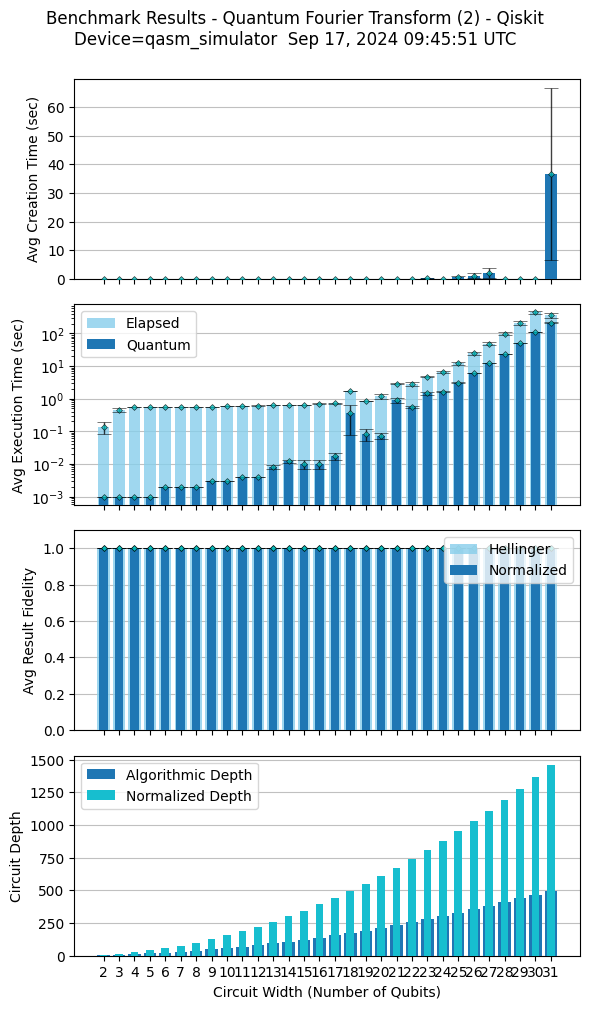

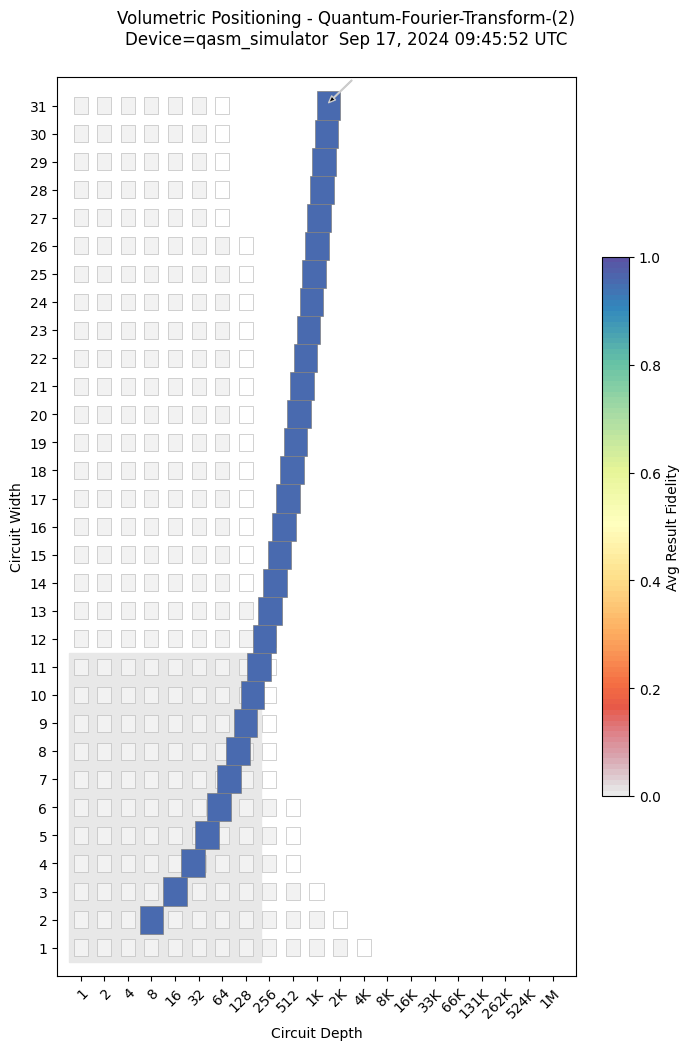

In [6]:
################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits = 2, max_qubits = 31, max_circuits = 3, skip_qubits=1, num_shots = 1000,
        method=2, input_value=None, 
        backend_id='qasm_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, input_size, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(input_size)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots, method)
        metrics.store_metric(input_size, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1, skip_qubits):
        
        # reset random seed 
        np.random.seed(0)

        num_qubits = input_size

        # determine number of circuits to execute for this group
        # and determine range of secret strings to loop over
        if method == 1 or method == 2:
            num_circuits = min(2 ** (input_size), max_circuits)
        
            if 2**(input_size) <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.randint(0, 2**(input_size), num_circuits + 2)
                s_range = list(set(s_range))[0:num_circuits]
         
        elif method == 3:
            num_circuits = min(input_size, max_circuits)

            if input_size <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(range(input_size), num_circuits, False)
                # s_range = np.random.randint(0, 2**(input_size), num_circuits + 2)    #this will give error
                # s_range = list(set(s_range))[0:num_circuits]
        
        else:
            sys.exit("Invalid QFT method")

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            s_int = int(s_int)

            # if user specifies input_value, use it instead
            # DEVNOTE: if max_circuits used, this will generate separate bar for each num_circuits
            if input_value is not None:
                s_int = input_value
                
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = QuantumFourierTransform(num_qubits, s_int, method=method)
            metrics.store_metric(input_size, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc2 = qc.decompose()
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)

            ex.submit_circuit(qc2, input_size, s_int, num_shots)
        
        print(f"... number of gates, depth = {num_gates}, {depth}")
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    
    ##########
    
    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method==1:
        print("\nQFT Circuit ="); print(QFT_)
    print("\nInverse QFT Circuit ="); print(QFTI_)
     
    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit")

# if main, execute method 1
if __name__ == '__main__': run()
